# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('Wholesale customers data.csv')

In [5]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [4]:
# Your code here:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [30]:
customers.value_counts()

Channel  Region  Fresh  Milk   Grocery  Frozen  Detergents_Paper  Delicassen
1        1       514    8323   6869     529     93                1040          1
         3       43088  2100   2609     1200    1107              823           1
2        1       1073   9679   15445    61      5980              1265          1
                 572    9763   22182    2221    4882              2563          1
                 18     7504   15205    1285    4797              6372          1
                                                                               ..
1        3       4446   906    1238     3576    153               1014          1
                 4420   5139   2661     8872    1321              181           1
                 4020   3234   1498     2395    264               255           1
                 3884   3801   1641     876     397               4829          1
2        3       44466  54259  55571    7782    24171             6465          1
Length: 440, dtype: i

In [6]:
customers.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [7]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [10]:
customers.shape

(440, 8)

In [16]:
customers_cols = customers[['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen','Detergents_Paper', 'Delicassen']]  

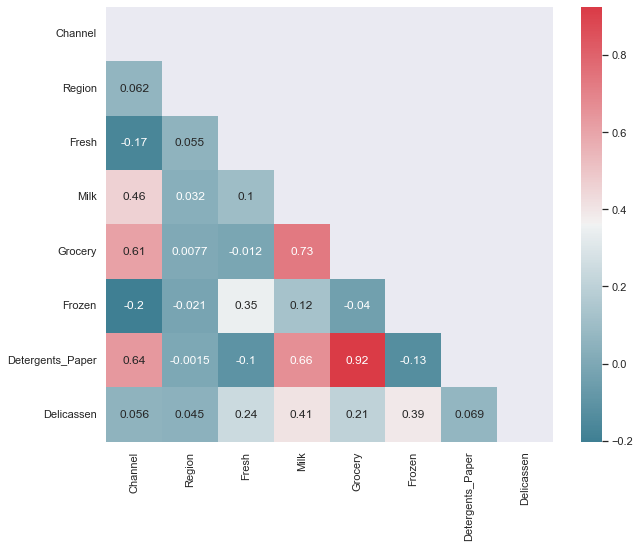

In [22]:
corr = customers_cols.corr()
sns.set(rc = {'figure.figsize':(10,8)})
matrix = np.triu(corr)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cbar=True, annot=True, mask=matrix, cmap=cmap)
plt.show()

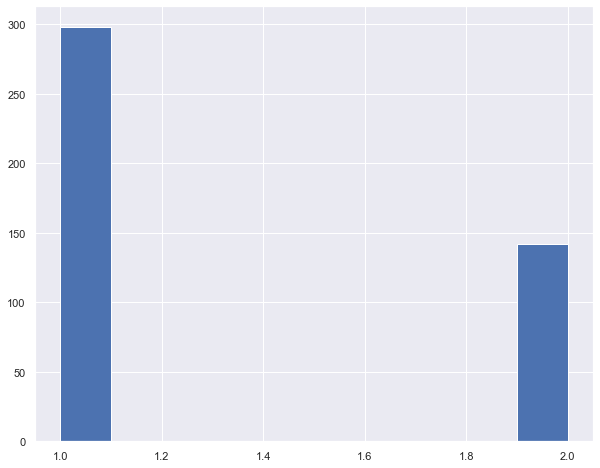

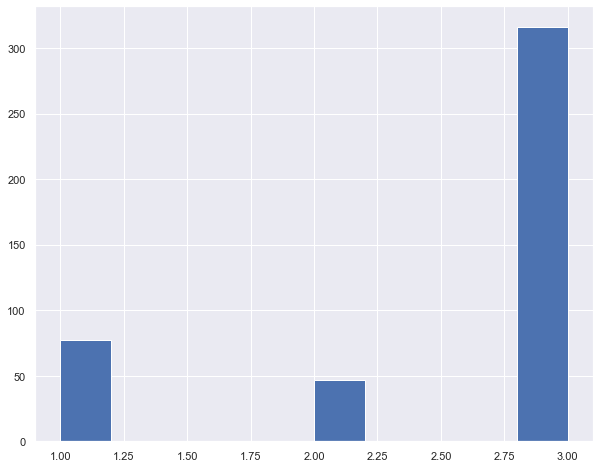

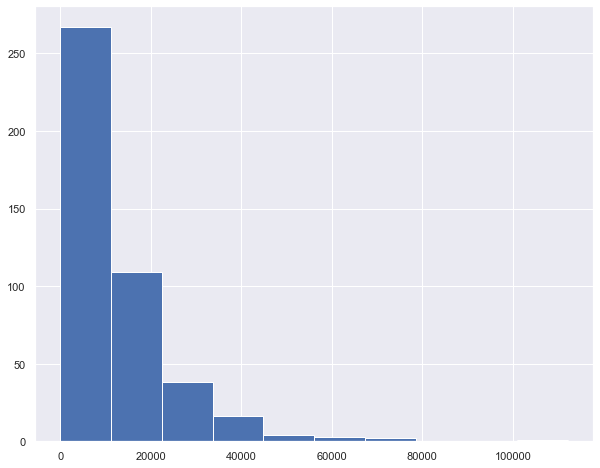

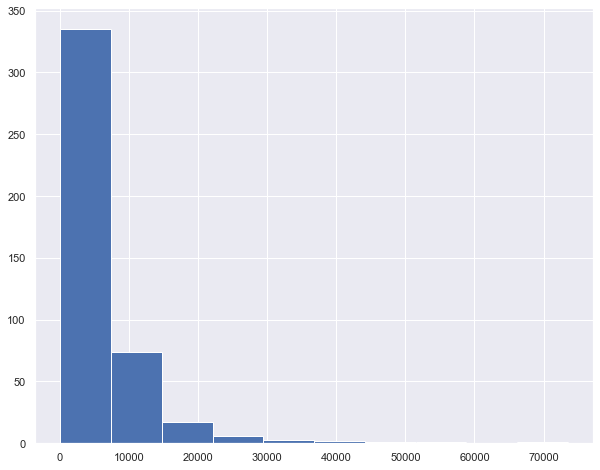

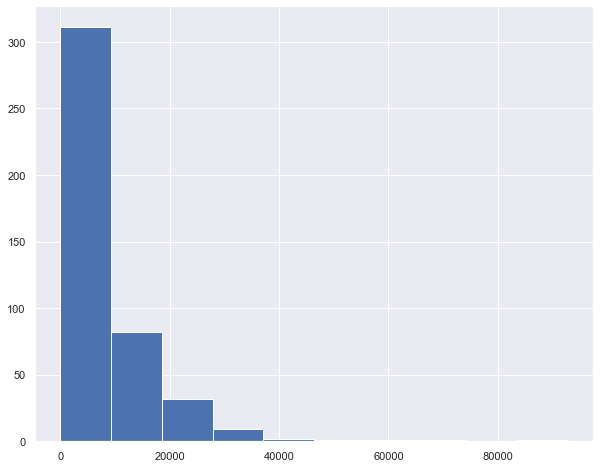

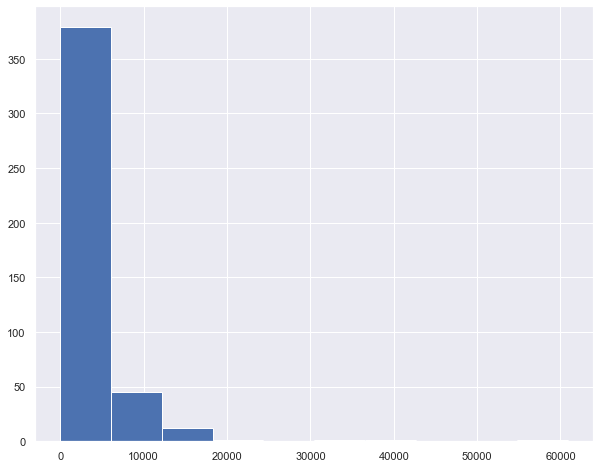

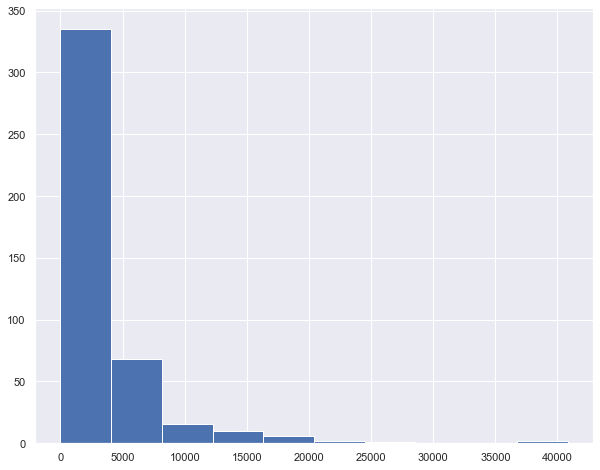

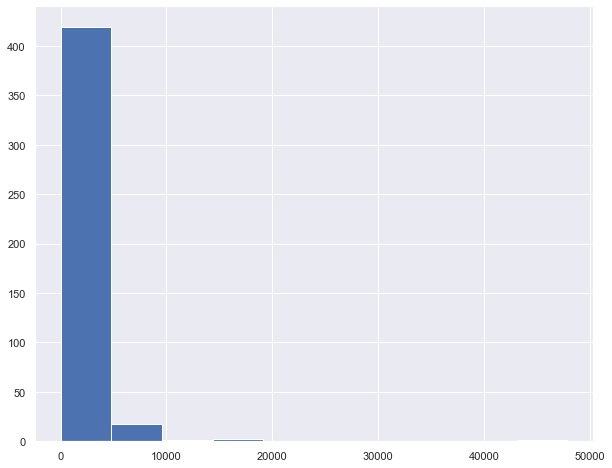

In [25]:
for col in customers.columns:
    plt.figure()
    plt.hist(customers[col], bins= 10)
    plt.show()

In [23]:
# Your observations here
#no missing data, no categorical data, 
#high corr: grocery/detergents_paper, milk/grocery, milk/detergents_paper,channel/detergents_paper and milk/channel
#positive skewdness in some of the cols


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [ ]:
# Your code here

In [ ]:
# Your comment here
#like said before, data seems ok

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [32]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
customers_sc = scaler.fit_transform(customers)

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [34]:
# Your code here:
from sklearn.cluster import KMeans
kmeans = KMeans()
kmeans.fit(customers_sc)
customers['labels'] = kmeans.labels_


In [35]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
0,2,3,12669,9656,7561,214,2674,1338,6
1,2,3,7057,9810,9568,1762,3293,1776,6
2,2,3,6353,8808,7684,2405,3516,7844,6
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,6


Count the values in `labels`.

In [36]:
# Your code here:
customers["labels"].value_counts()

0    164
6     98
3     85
2     54
1     33
4      4
7      1
5      1
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [38]:
# Your code here
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=.5)
model_dbs = dbs.fit(customers_sc)
customers['labels_DBSCAN'] = model_dbs.labels_

Count the values in `labels_DBSCAN`.

In [39]:
# Your code here
customers["labels_DBSCAN"].value_counts()

-1    255
 1    130
 5     22
 4      7
 6      6
 0      5
 3      5
 2      5
 7      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

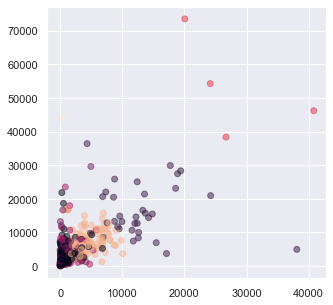

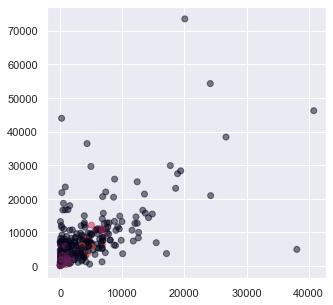

In [44]:
# Your code here:
plt.figure(figsize=(5,5))
plt.scatter(customers['Detergents_Paper'], customers['Milk'], c=customers['labels'], alpha=0.5)
plt.figure(figsize=(5,5))
plt.scatter(customers['Detergents_Paper'], customers['Milk'], c=customers['labels_DBSCAN'], alpha=0.5)
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

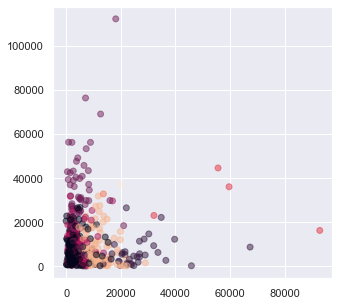

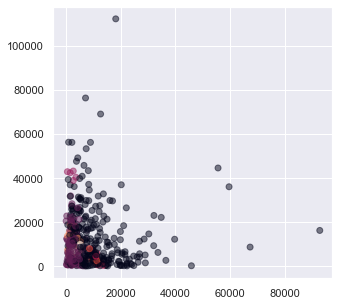

In [45]:
# Your code here:
plt.figure(figsize=(5,5))
plt.scatter(customers['Grocery'], customers['Fresh'], c=customers['labels'], alpha=0.5)
plt.figure(figsize=(5,5))
plt.scatter(customers['Grocery'], customers['Fresh'], c=customers['labels_DBSCAN'], alpha=0.5)
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

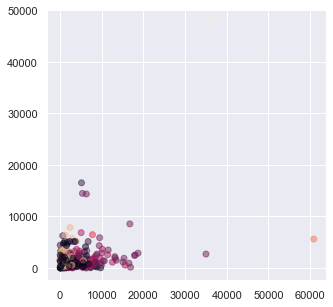

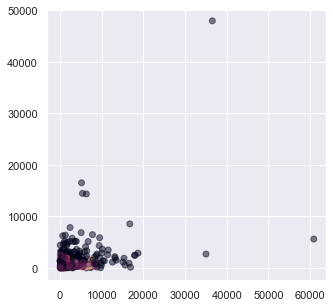

In [46]:
# Your code here:
plt.figure(figsize=(5,5))
plt.scatter(customers['Frozen'], customers['Delicassen'], c=customers['labels'], alpha=0.5)
plt.figure(figsize=(5,5))
plt.scatter(customers["Frozen"], customers["Delicassen"], c=customers["labels_DBSCAN"], alpha=0.5)
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [48]:
# Your code here:
labels_mean = customers.groupby(['labels', 'labels_DBSCAN']).agg('mean')

labels_mean


Channel    Region         Fresh          Milk  \
labels labels_DBSCAN                                                   
0      -1             1.000000  3.000000   7995.487179   6377.846154   
        1             1.000000  3.000000   8480.200000   1876.512000   
1      -1             2.000000  2.272727   6063.606061  16458.909091   
2      -1             1.068182  2.772727  34088.204545   5096.931818   
        1             1.000000  3.000000  25344.400000   1510.600000   
        2             1.000000  3.000000  41446.600000   1421.200000   
3      -1             1.076923  1.403846  11154.461538   4148.673077   
        5             1.000000  1.000000   9837.863636   1751.863636   
        6             1.000000  1.000000   6823.000000   1943.000000   
        7             1.000000  2.000000   7494.600000   1537.600000   
4      -1             2.000000  3.000000  29862.500000  53080.750000   
5      -1             1.000000  2.000000  32717.000000  16784.000000   
6      -1             2.000000  2.728395   8891.222222   7738.740741   
        0             2.000000  3.000000  11401.000000   3536.200000   
        3             2.000000  3.000000   2357.200000  10224.800000   
        4             2.000000  3.000000   3068.142857   6095.857143   
7      -1             1.000000  3.000000  36847.000000  43950.000000   

                           Grocery        Frozen  Detergents_Paper  \
labels labels_DBSCAN                                                 
0      -1              6689.820513   2456.769231       1729.794872   
        1              2445.744000   2028.880000        500.584000   
1      -1             26891.363636   1788.212121      13102.969697   
2      -1              5752.750000   9219.977273        880.772727   
        1              1868.200000   4695.200000        396.400000   
        2              2167.600000   1276.400000        416.200000   
3      -1              5154.750000   3458.826923       1220.961538   
        5              2161.681818   1513.181818        333.954545   
        6              2372.666667   6780.333333        386.500000   
        7              3383.000000   2575.400000        227.400000   
4      -1             60015.750000   3262.250000      27942.250000   
5      -1             13626.000000  60869.000000       1272.000000   
6      -1             12162.567901   1443.345679       4883.950617   
        0              6729.000000    720.200000       3561.000000   
        3             11862.800000    609.600000       5780.000000   
        4             10355.000000    994.000000       4675.571429   
7      -1             20170.000000  36534.000000        239.000000   

                        Delicassen  
labels labels_DBSCAN                
0      -1              1772.307692  
        1               737.096000  
1      -1              2417.515152  
2      -1              2711.409091  
        1               863.200000  
        2               784.800000  
3      -1              1320.519231  
        5               669.045455  
        6               613.666667  
        7               941.000000  
4      -1              3082.250000  
5      -1              5609.000000  
6      -1              1577.432099  
        0               258.200000  
        3               572.800000  
        4              1826.428571  
7      -1             47943.000000

Which algorithm appears to perform better?

In [ ]:
# Your observations here
#kmean?

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here